In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

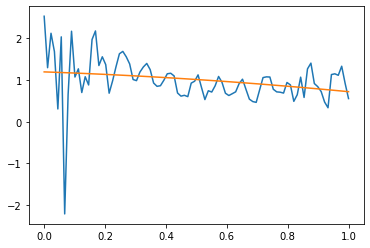

In [140]:
def tanh(x, a, b, c, d):
    return d + a*(1 - np.exp(-2*b*(x - c)))/(1 + np.exp(-2*b*(x - c)))

y = np.array([ 2.53444834,  1.29839826,  2.12567736,  1.68491959,  0.30719816,
               2.03921835, -2.21389361,  0.65146105,  2.17400376,  1.07440058,
               1.27088244,  0.7021657 ,  1.08158121,  0.88390459,  1.97486261,
               2.18127158,  1.35044717,  1.56053974,  1.37238021,  0.68595416,
               0.97933556,  1.31938937,  1.63256274,  1.68976574,  1.56069396,
               1.38868713,  1.01459752,  0.98762897,  1.19343952,  1.31562195,
               1.40062881,  1.25166442,  0.93065927,  0.8508729 ,  0.86572389,
               0.99759427,  1.15234267,  1.16510213,  1.10032437,  0.69125199,
               0.61540056,  0.63528541,  0.6036495 ,  0.92830299,  0.97396159,
               1.1261418 ,  0.82554978,  0.53274701,  0.74502987,  0.71385674,
               0.86454217,  1.08778154,  0.94655936,  0.68552462,  0.6304205 ,
               0.67366643,  0.71898202,  0.91553078,  1.02274545,  0.78086267,
               0.54372404,  0.48466796,  0.46600064,  0.76528263,  1.06106885,
               1.07848824,  1.07413992,  0.78059478,  0.71770195,  0.71002082,
               0.68888306,  0.94284608,  0.88556398,  0.49011939,  0.64872396,
               1.07112544,  0.58410991,  1.26975144,  1.40841865,  0.91846669,
               0.84291321,  0.72509505,  0.47390028,  0.33605206,  1.13365434,
               1.15193504,  1.11608076,  1.33395766,  0.92361073,  0.55689185], dtype=np.float64)
t = np.linspace(0, 1, len(y), dtype=np.float32)


g = tf.math.polyval([-0.21892595, -0.25625   ,  1.1976796 ], t)

plt.plot(t, y)
plt.plot(t, g)

In [141]:
# Specify model.
def make_prior(dims):
    return tfd.MultivariateNormalDiag(
      loc=tf.zeros(dims),
        scale_diag=[1, 1, 1, 10.])

def make_likelihood(weights, factors):
    return tfd.MultivariateNormalDiag(
      loc=tf.matmul(weights, factors, adjoint_b=True))

# Setup data.
num_weights = 4 # == d
num_factors = len(y) # == n
num_chains = 100

# weights = np.array([[0.23, 3]], dtype=np.float32)
# factors = tf.random.normal([num_factors, num_weights])
factors = np.c_[t**3, t**2, t, np.ones(len(t), dtype=np.float32)]
# x = make_likelihood(weights, factors).sample()
x = y

def unnormalized_log_posterior(w):
    def joint_log_prob(num_weights, factors, x, w):
        return (make_prior(num_weights).log_prob(w) + make_likelihood(w, factors).log_prob(x))
    return joint_log_prob(num_weights, factors, x, w)

# Sample from Hamiltonian Monte Carlo Markov Chain.

# Get `num_results` samples from `num_chains` independent chains.
chains_states, kernels_results = tfp.mcmc.sample_chain(
    num_results=2000,
    num_burnin_steps=1000,
    current_state=tf.zeros([num_chains, num_weights], name='init_weights'),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_log_posterior,
      step_size=0.01,
      num_leapfrog_steps=2))

# Compute sample stats.
sample_mean = tf.reduce_mean(chains_states, axis=[0, 1])
# ==> approx equal to weights

sample_var = tf.reduce_mean(
    (chains_states - sample_mean)**2,
    axis=[0, 1])
# ==> less than 1

c:\program files\python38\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [137]:
chains_states.numpy().any()

True

In [138]:
sample_mean

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.21892595, -0.25625   ,  1.1976796 ], dtype=float32)>

In [139]:
sample_var

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.28635   , 0.2681291 , 0.03971221], dtype=float32)>